# Particle Filter 

In [ ]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def simulate_ball_trajectory(launch_pos, launch_speed, launch_angle, dt, ground_level, num_steps):
    # simulates the true trajectory of a ball
    trajectory = np.zeros((num_steps, 4))  # [x, vx, y, vy]
    trajectory[0] = [launch_pos[0], launch_speed * np.cos(np.radians(launch_angle)),
                     launch_pos[1], launch_speed * np.sin(np.radians(launch_angle))]

    for i in range(1, num_steps):
        x, vx, y, vy = trajectory[i - 1]

        # Update x position and velocity
        trajectory[i, 0] = x + vx * dt
        trajectory[i, 1] = vx

        # Update y position and velocity
        trajectory[i, 2] = y + vy * dt
        trajectory[i, 3] = vy - 9.8 * dt

        # Check if ball hits the ground
        if trajectory[i, 2] <= ground_level:
            trajectory[i, 2] = ground_level
            trajectory[i, 3] = 0  # Set vertical velocity to zero when ball reaches the ground
            break  # Exit the loop when ball reaches the ground

    # trim trajectory to the actual number of steps taken
    trajectory = trajectory[:i+1]

    return trajectory

In [19]:
def simulate_observation(true_trajectory, observation_error, dt, observation_drop_prob):
    # simulates the observed trajectory with noise and dropped observations
    num_steps = len(true_trajectory)
    observed_trajectory = np.zeros_like(true_trajectory)

    for i in range(num_steps):
        if np.random.rand() > observation_drop_prob:  # Simulate dropped observations
            true_state = true_trajectory[i]
            observed_trajectory[i] = true_state + np.random.normal(0, observation_error, size=(4,))

    return observed_trajectory

In [20]:
def run_particle_filter(observed_trajectory, dt, process_error, observation_error, num_particles):
    num_steps = len(observed_trajectory)
    num_states = observed_trajectory.shape[1]

    # initialize particles
    particles = np.zeros((num_steps, num_particles, num_states))
    particles[0] = np.tile(observed_trajectory[0], (num_particles, 1)) + np.random.normal(0, process_error, size=(num_particles, num_states))

    for i in range(1, num_steps):
        # predict step
        particles[i] = particles[i - 1] + np.random.normal(0, process_error, size=(num_particles, num_states))

        # update step
        weights = calculate_weights(particles[i], observed_trajectory[i], observation_error)
        indices = systematic_resampling(weights)
        particles[i], _ = resample_particles(particles[i], indices)

    # Calculate estimated trajectory
    estimated_trajectory = np.mean(particles, axis=1)

    return estimated_trajectory, particles

In [ ]:
def calculate_weights(particles, observation, observation_error):
    num_particles = particles.shape[0]
    weights = np.zeros(num_particles)

    for i in range(num_particles):
        diff = particles[i] - observation
        likelihood = np.exp(-0.5 * np.sum(diff ** 2) / observation_error ** 2)
        weights[i] = likelihood

    # normalize weights
    sum_weights = np.sum(weights)
    if sum_weights != 0:
        weights /= sum_weights
    else:
        weights[:] = 1 / num_particles

    return weights

In [21]:
def systematic_resampling(weights):
    num_particles = weights.shape[0]
    cumulative_weights = np.cumsum(weights)
    indices = np.zeros(num_particles, dtype=int)
    u = np.random.uniform(0, 1 / num_particles)
    j = 0

    for i in range(num_particles):
        while u > cumulative_weights[j]:
            j += 1
        indices[i] = j
        u += 1 / num_particles

    return indices

In [22]:
def resample_particles(particles, indices):
    num_particles = particles.shape[0]
    num_states = particles.shape[1]
    new_particles = np.zeros_like(particles)

    for i in range(num_particles):
        new_particles[i] = particles[indices[i]]

    new_weights = np.ones(num_particles) / num_particles

    return new_particles, new_weights

In [23]:
# User parameters
launch_pos = [0, 0]
launch_speed = 30
launch_angle = 45
dt = 0.01
ground_level = 0
num_steps = 1000
observation_error = 1
observation_drop_prob = 0.01
process_error = 0.5
num_particles = 1000

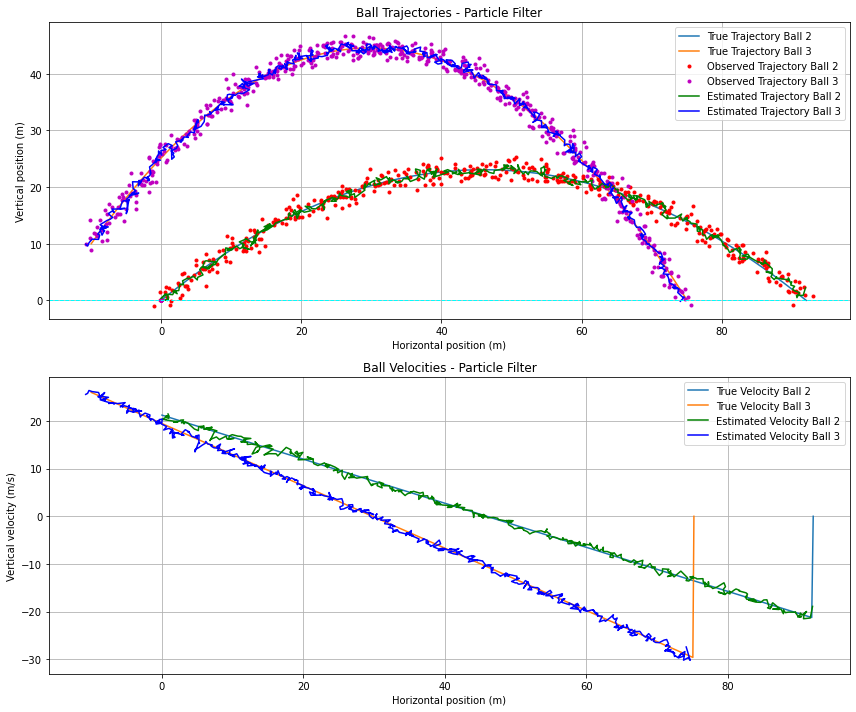

In [10]:
#plotting

# simulate true ball trajectory
true_trajectory1 = simulate_ball_trajectory(launch_pos, launch_speed, launch_angle, dt, ground_level, num_steps)
true_trajectory2 = simulate_ball_trajectory([-10, 10], launch_speed, 60, dt, ground_level, num_steps)

# simulate observed trajectory with noise and dropped observations
observed_trajectory1 = simulate_observation(true_trajectory1, observation_error, dt, observation_drop_prob)
observed_trajectory2 = simulate_observation(true_trajectory2, observation_error, dt, observation_drop_prob)

# run the Particle Filter (Condensation Algorithm)
estimated_trajectory1, particles1 = run_particle_filter(observed_trajectory1, dt, process_error, observation_error,
                                                       num_particles)
estimated_trajectory2, particles2 = run_particle_filter(observed_trajectory2, dt, process_error, observation_error,
                                                       num_particles)

# plotting trajectories and velocities
plt.figure(figsize=(12, 10))

# plotting trajectories
plt.subplot(2, 1, 1)
plt.plot(true_trajectory1[:, 0], true_trajectory1[:, 2], label='True Trajectory Ball 2')
plt.plot(true_trajectory2[:, 0], true_trajectory2[:, 2], label='True Trajectory Ball 3')
plt.plot(observed_trajectory1[:, 0], observed_trajectory1[:, 2], 'r.', label='Observed Trajectory Ball 2')
plt.plot(observed_trajectory2[:, 0], observed_trajectory2[:, 2], 'm.', label='Observed Trajectory Ball 3')
plt.plot(estimated_trajectory1[:, 0], estimated_trajectory1[:, 2], 'g-', label='Estimated Trajectory Ball 2')
plt.plot(estimated_trajectory2[:, 0], estimated_trajectory2[:, 2], 'b-', label='Estimated Trajectory Ball 3')

plt.axhline(0, color='cyan', linestyle='--', linewidth=1)  # Add horizontal line at y=0 (ground line)
plt.xlabel('Horizontal position (m)')
plt.ylabel('Vertical position (m)')
plt.title('Ball Trajectories - Particle Filter')
plt.legend(loc='upper right', frameon=True)
plt.grid(True)

# plotting velocities
plt.subplot(2, 1, 2)
plt.plot(true_trajectory1[:, 0], true_trajectory1[:, 3], label='True Velocity Ball 2')
plt.plot(true_trajectory2[:, 0], true_trajectory2[:, 3], label='True Velocity Ball 3')
#plt.plot(observed_trajectory1[:, 0], observed_trajectory1[:, 3], 'r.', label='Observed Velocity Ball 2')
#plt.plot(observed_trajectory2[:, 0], observed_trajectory2[:, 3], 'm.', label='Observed Velocity Ball 3')
plt.plot(estimated_trajectory1[:, 0], estimated_trajectory1[:, 3], 'g-', label='Estimated Velocity Ball 2')
plt.plot(estimated_trajectory2[:, 0], estimated_trajectory2[:, 3], 'b-', label='Estimated Velocity Ball 3')

plt.xlabel('Horizontal position (m)')
plt.ylabel('Vertical velocity (m/s)')
plt.title('Ball Velocities - Particle Filter')
plt.legend(loc='upper right', frameon=True)
plt.grid(True)

plt.tight_layout()
plt.show()
